c:\Users\sse\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 4, 4, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 1280)       │         5,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,103,490 (15.65 MB)

 Trainable params: 3,047,490 (11.63 MB)

 Non-trainable params: 1,056,000 (4.03 MB)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 10s/step - accuracy: 0.5807 - loss: 8.2444 - val_accuracy: 0.3846 - val_loss: 7.5416 - learning_rate: 1.0000e-04
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3464 - loss: 7.7789 - val_accuracy: 0.3846 - val_loss: 7.5284 - learning_rate: 1.0000e-04
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5078 - loss: 7.9923 - val_accuracy: 0.3846 - val_loss: 7.5106 - learning_rate: 1.0000e-04
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4948 - loss: 7.5673 - val_accuracy: 0.4615 - val_loss: 7.4890 - learning_rate: 1.0000e-04
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5078 - loss: 7.4937 - val_accuracy: 0.6154 - val_loss: 7.4619 - learning_rate: 1.0000e-04
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5312 - loss: 7.7095 - val_accuracy: 0.6923 - val_loss: 7.4403 - learning_rate: 1.0000e-04
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6068 - loss: 7.4098 - val_accur

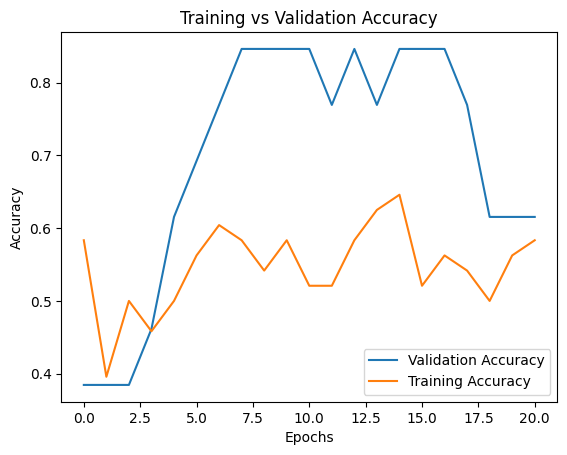

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

# Constants
IMAGE_SIZE = (128, 128)  # Image dimensions (height, width)
SEQUENCE_LENGTH = 10  # Number of frames in each sequence
NUM_CLASSES = 2  # Left blink and right blink

# Data Augmentation (Customized for eye images)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),  
    layers.RandomZoom(0.1),  
    layers.RandomContrast(0.2),
])

# Load and preprocess images with augmentation
def load_eye_data(eye_folder, label, sequence_length=SEQUENCE_LENGTH):
    images = []
    
    # Load images from the folder
    for file_name in sorted(os.listdir(eye_folder)):
        img_path = os.path.join(eye_folder, file_name)
        
        # Attempt to read the image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to load image {file_name}. Skipping...")
            continue  # Skip if image can't be loaded
        
        # Resize to fixed size and normalize
        img = cv2.resize(img, IMAGE_SIZE)  # Resize to fixed size
        img = img.astype('float32') / 255.0  # Normalize the image
        
        # Add batch dimension for augmentation and apply augmentation
        img = np.expand_dims(img, axis=0)  
        img = data_augmentation(img)  # Apply augmentation
        img = tf.squeeze(img, axis=0)  # Remove batch dimension

        images.append(img)
    
    # Pad sequences if the number of images is less than SEQUENCE_LENGTH
    num_images = len(images)
    if num_images < sequence_length:
        # If there are fewer images than required, pad with the last image
        padding_needed = sequence_length - num_images
        images.extend([images[-1]] * padding_needed)

    # Create sequences
    sequences = []
    for i in range(0, len(images) - sequence_length + 1, sequence_length):
        sequences.append(images[i:i + sequence_length])

    labels = [label] * len(sequences)
    return np.array(sequences), np.array(labels)

# Load dataset
def load_dataset(base_folder):
    blinks = ['left_blink', 'right_blink']
    X, y = [], []
    
    # Iterate over left and right blink folders
    for i, blink in enumerate(blinks):
        blink_folder = os.path.join(base_folder, blink)
        sequences, labels = load_eye_data(blink_folder, i)
        if len(sequences) > 0:
            X.append(sequences)
            y.append(labels)

    # Concatenate sequences and labels properly
    X = np.concatenate(X, axis=0)  # Shape should be (num_sequences, sequence_length, height, width, channels)
    y = np.concatenate(y, axis=0)  # Shape should be (num_sequences,)
    return X, y

# Load the dataset
base_folder = "eye_img"
X, y = load_dataset(base_folder)

# Shuffle the data
shuffle_indices = np.random.permutation(len(X))
X = X[shuffle_indices]
y = y[shuffle_indices]

# Split into training and validation sets
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)

# Calculate class weights for handling class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

# Create the CNN-LSTM model for eye blink recognition
def create_cnn_lstm_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                   include_top=False,
                                                   weights='imagenet')

    base_model.trainable = True
    for layer in base_model.layers[:-20]:  # Unfreeze more layers for better fine-tuning
        layer.trainable = False

    model = models.Sequential()
    model.add(layers.TimeDistributed(base_model, input_shape=(SEQUENCE_LENGTH, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(layers.TimeDistributed(layers.GlobalAveragePooling2D()))
    
    # Batch normalization and LSTM layers
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.LSTM(256, return_sequences=False, dropout=0.2))  # Dropout for regularization

    # Fully connected layers with regularization
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),  
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Callbacks for training
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Create the model
model = create_cnn_lstm_model()

# Print the model summary
model.summary()

# Train the model with class weights and callbacks
history = model.fit(X_train, y_train, 
                    epochs=50,
                    batch_size=16, 
                    validation_data=(X_val, y_val),
                    class_weight=class_weights_dict,  
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the model
model.save("gaze_tracking_cnn_lstm_mobilenet_model.keras")

# Plot the training and validation accuracy over epochs
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


VGG-19 Based CNN-LSTM Model

c:\Users\sse\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 140s 31s/step - accuracy: 0.6560 - loss: 7.5228 - val_accuracy: 0.8125 - val_loss: 7.3883
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 72s 17s/step - accuracy: 0.5933 - loss: 7.4732 - val_accuracy: 0.8125 - val_loss: 7.3296
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 66s 18s/step - accuracy: 0.5804 - loss: 7.4074 - val_accuracy: 0.8125 - val_loss: 7.2733
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 64s 17s/step - accuracy: 0.6262 - loss: 7.4113 - val_accuracy: 0.8125 - val_loss: 7.2245
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 65s 17s/step - accuracy: 0.6073 - loss: 7.3859 - val_accuracy: 0.8125 - val_loss: 7.1881
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 66s 17s/step - accuracy: 0.7020 - loss: 7.2452 - val_accuracy: 0.8125 - val_loss: 7.1564
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 68s 18s/step - accuracy: 0.5514 - loss: 7.2130 - val_accuracy: 0.8125 - val_loss: 7.1206
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 66s 17s/step - accuracy: 0.5229 - loss: 7.1903 - val_accuracy: 0.8125 - val_loss: 7.0891

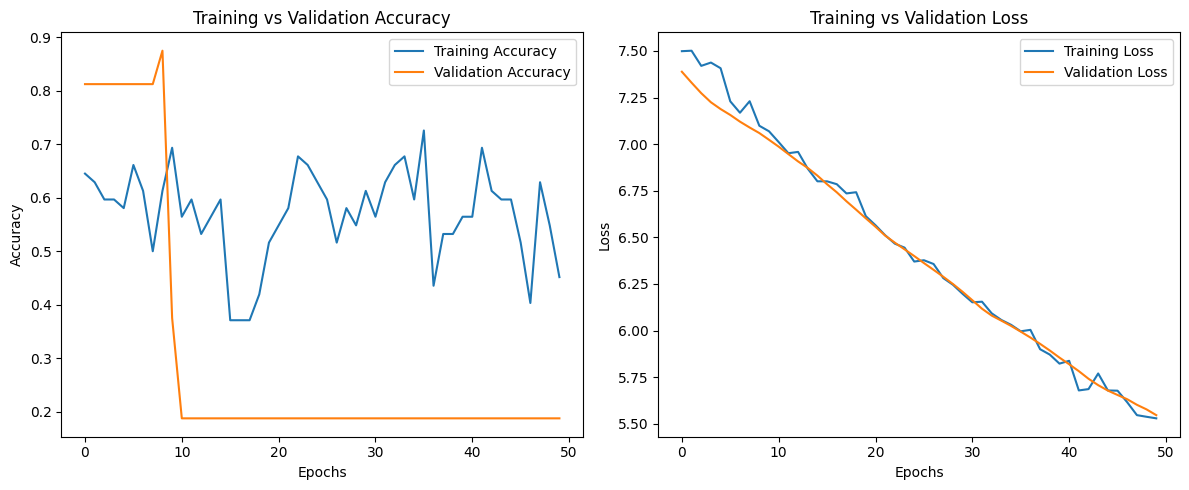

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
import numpy as np
import os
import cv2
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# Constants
IMAGE_SIZE = (128, 128)
SEQUENCE_LENGTH = 10
NUM_CLASSES = 2

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

# Load and preprocess images
def load_eye_data(eye_folder, label, sequence_length=SEQUENCE_LENGTH):
    images = []
    for file_name in sorted(os.listdir(eye_folder)):
        img_path = os.path.join(eye_folder, file_name)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.resize(img, IMAGE_SIZE)
        img = img.astype('float32') / 255.0
        img = data_augmentation(np.expand_dims(img, axis=0))
        images.append(tf.squeeze(img, axis=0))
    
    if len(images) < sequence_length:
        images.extend([images[-1]] * (sequence_length - len(images)))

    sequences = [images[i:i + sequence_length] for i in range(0, len(images) - sequence_length + 1, sequence_length)]
    labels = [label] * len(sequences)
    return np.array(sequences), np.array(labels)

# Load dataset
def load_dataset(base_folder):
    X, y = [], []
    for i, blink in enumerate(['left_blink', 'right_blink']):
        sequences, labels = load_eye_data(os.path.join(base_folder, blink), i)
        if len(sequences) > 0:
            X.append(sequences)
            y.append(labels)
    return np.concatenate(X, axis=0), np.concatenate(y, axis=0)

# Load and preprocess dataset
base_folder = "eye_img"
X, y = load_dataset(base_folder)

shuffle_indices = np.random.permutation(len(X))
X, y = X[shuffle_indices], y[shuffle_indices]

split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

# Create VGG-19 + CNN-LSTM Model
def create_vgg19_cnn_lstm_model():
    base_model = tf.keras.applications.VGG19(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    
    model = models.Sequential()
    model.add(layers.TimeDistributed(base_model, input_shape=(SEQUENCE_LENGTH, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(layers.TimeDistributed(layers.GlobalAveragePooling2D()))
    model.add(layers.LSTM(256, return_sequences=False, dropout=0.2))
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize model
model_vgg19 = create_vgg19_cnn_lstm_model()

# Train the model
history_vgg19 = model_vgg19.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict
)

# Evaluate the model
val_loss_vgg19, val_accuracy_vgg19 = model_vgg19.evaluate(X_val, y_val)
print(f"VGG-19 Validation Accuracy: {val_accuracy_vgg19 * 100:.2f}%")

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_vgg19.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg19.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_vgg19.history['loss'], label='Training Loss')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


VGG-16 Based CNN-LSTM Model Code

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
import numpy as np
import os
import cv2
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# Constants
IMAGE_SIZE = (128, 128)
SEQUENCE_LENGTH = 10
NUM_CLASSES = 2

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

# Load and preprocess images
def load_eye_data(eye_folder, label, sequence_length=SEQUENCE_LENGTH):
    images = []
    for file_name in sorted(os.listdir(eye_folder)):
        img_path = os.path.join(eye_folder, file_name)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.resize(img, IMAGE_SIZE)
        img = img.astype('float32') / 255.0
        img = data_augmentation(np.expand_dims(img, axis=0))
        images.append(tf.squeeze(img, axis=0))
    
    if len(images) < sequence_length:
        images.extend([images[-1]] * (sequence_length - len(images)))

    sequences = [images[i:i + sequence_length] for i in range(0, len(images) - sequence_length + 1, sequence_length)]
    labels = [label] * len(sequences)
    return np.array(sequences), np.array(labels)

# Load dataset
def load_dataset(base_folder):
    X, y = [], []
    for i, blink in enumerate(['left_blink', 'right_blink']):
        sequences, labels = load_eye_data(os.path.join(base_folder, blink), i)
        if len(sequences) > 0:
            X.append(sequences)
            y.append(labels)
    return np.concatenate(X, axis=0), np.concatenate(y, axis=0)

# Load and preprocess dataset
base_folder = "eye_img"
X, y = load_dataset(base_folder)

shuffle_indices = np.random.permutation(len(X))
X, y = X[shuffle_indices], y[shuffle_indices]

split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

# Create VGG-16 + CNN-LSTM Model
def create_vgg16_cnn_lstm_model():
    base_model = tf.keras.applications.VGG16(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential()
    model.add(layers.TimeDistributed(base_model, input_shape=(SEQUENCE_LENGTH, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(layers.TimeDistributed(layers.GlobalAveragePooling2D()))
    model.add(layers.LSTM(256, return_sequences=False, dropout=0.2))
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize model
model_vgg16 = create_vgg16_cnn_lstm_model()

# Train the model
history_vgg16 = model_vgg16.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict
)

# Evaluate the model
val_loss_vgg16, val_accuracy_vgg16 = model_vgg16.evaluate(X_val, y_val)
print(f"VGG-16 Validation Accuracy: {val_accuracy_vgg16 * 100:.2f}%")

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG-16: Training vs Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16: Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 109s 14s/step - accuracy: 0.6075 - loss: 7.4512 - val_accuracy: 0.2500 - val_loss: 7.4887
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 13s/step - accuracy: 0.6353 - loss: 7.3740 - val_accuracy: 0.5000 - val_loss: 7.4066
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 13s/step - accuracy: 0.6543 - loss: 7.4799 - val_accuracy: 0.2500 - val_loss: 7.3570
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 13s/step - accuracy: 0.6566 - loss: 7.2954 - val_accuracy: 0.3125 - val_loss: 7.3015
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 13s/step - accuracy: 0.5279 - loss: 7.2962 - val_accuracy: 0.3750 - val_loss: 7.2524
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 13s/step - accuracy: 0.8101 - loss: 7.2918 - val_accuracy: 0.2500 - val_loss: 7.2107
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 14s/step - accuracy: 0.6835 - loss: 7.1343 - val_accuracy: 0.2500 - val_loss: 7.1648
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 14s/step - accuracy: 0.7503 - loss: 7.0299 - val_accuracy: 0.2500 - val_loss: 7.1223